## Imports and Preliminaries

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import timm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from scipy.spatial.distance import cosine
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import timm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

Using device: cpu


## Dataset Class

In [6]:
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms


class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split="train", transform=None, cache=False):
        """
        Args:
            root_dir: Path to MVTec AD dataset root.
            category: Product category (e.g., 'bottle', 'cable', 'capsule').
            split: 'train' or 'test'.
            transform: torchvision transforms.
            cache: If True, images are pre-loaded into RAM for faster epochs.
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        self.cache = cache

        base_dir = self.root_dir / category / split

        if split == "train":
            img_dirs = [(base_dir / "good", 0, "good")]
        else:
            # Each folder inside 'test' is a defect type
            img_dirs = [
                (d, 0 if d.name == "good" else 1, d.name)
                for d in base_dir.iterdir()
                if d.is_dir()
            ]

        self.image_paths = []
        self.labels = []
        self.defect_types = []

        for folder, lbl, defect in img_dirs:
            for img_path in sorted(folder.glob("*.png")):
                self.image_paths.append(img_path)
                self.labels.append(lbl)
                self.defect_types.append(defect)

        # Optional RAM caching
        self.cached_images = None
        if cache:
            self.cached_images = [
                Image.open(p).convert("RGB") for p in self.image_paths
            ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # if self.cache:
        #     img = self.cached_images[idx]
        # else:
        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        defect_type = self.defect_types[idx]

        return img, defect_type

## Create Datasets

In [48]:
from torch.utils.data import ConcatDataset
import os

MVTEC_ROOT = "./Dataset"
BATCH_SIZE = 8
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

root_dir = Path(MVTEC_ROOT)

#all_categories = [cat.name for cat in root_dir.iterdir() if cat.is_dir()]
all_categories = ["bottle", "carpet", "leather", "tile"]
print(all_categories)


def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )

transform = get_transforms(IMAGE_SIZE)

def build_concat(split):
    datasets = [
        MVTecDataset(MVTEC_ROOT, cat, split=split, transform=transform)
        for cat in all_categories
    ]
    return ConcatDataset(datasets)


train_dataset = build_concat("train")
test_dataset = build_concat("test")

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

['bottle', 'carpet', 'leather', 'tile']


TRAINING IMAGES


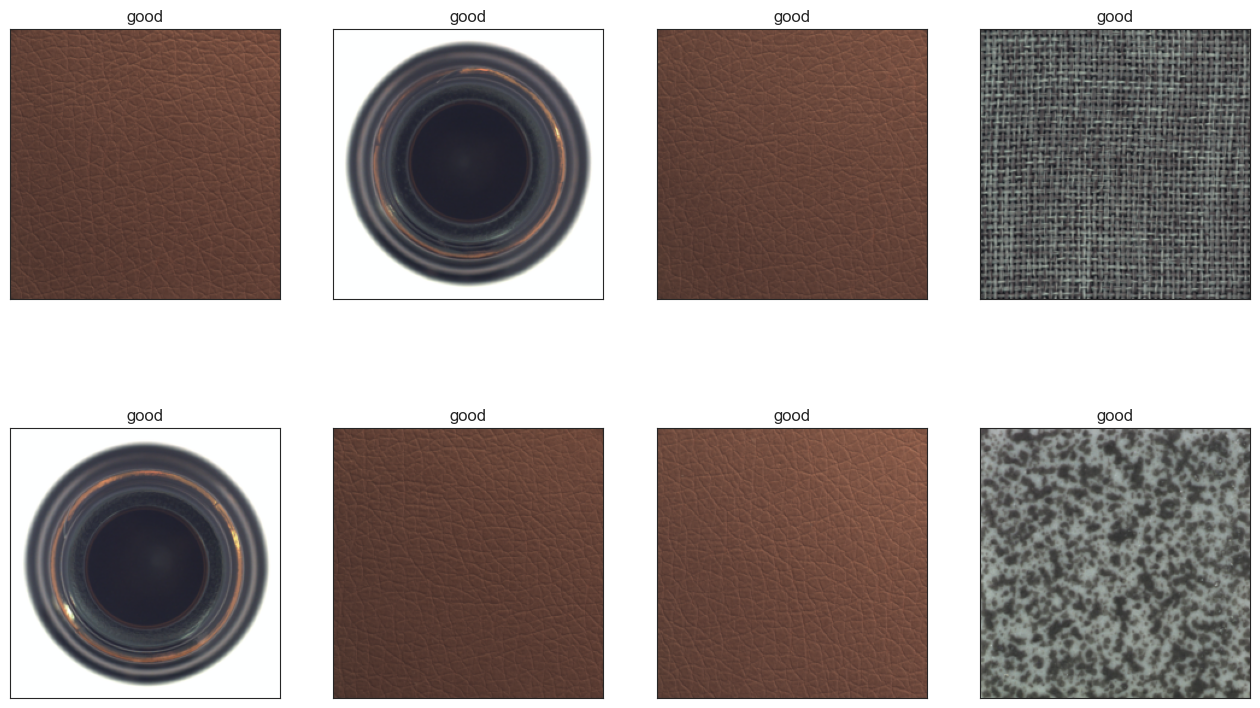

TESTING IMAGES


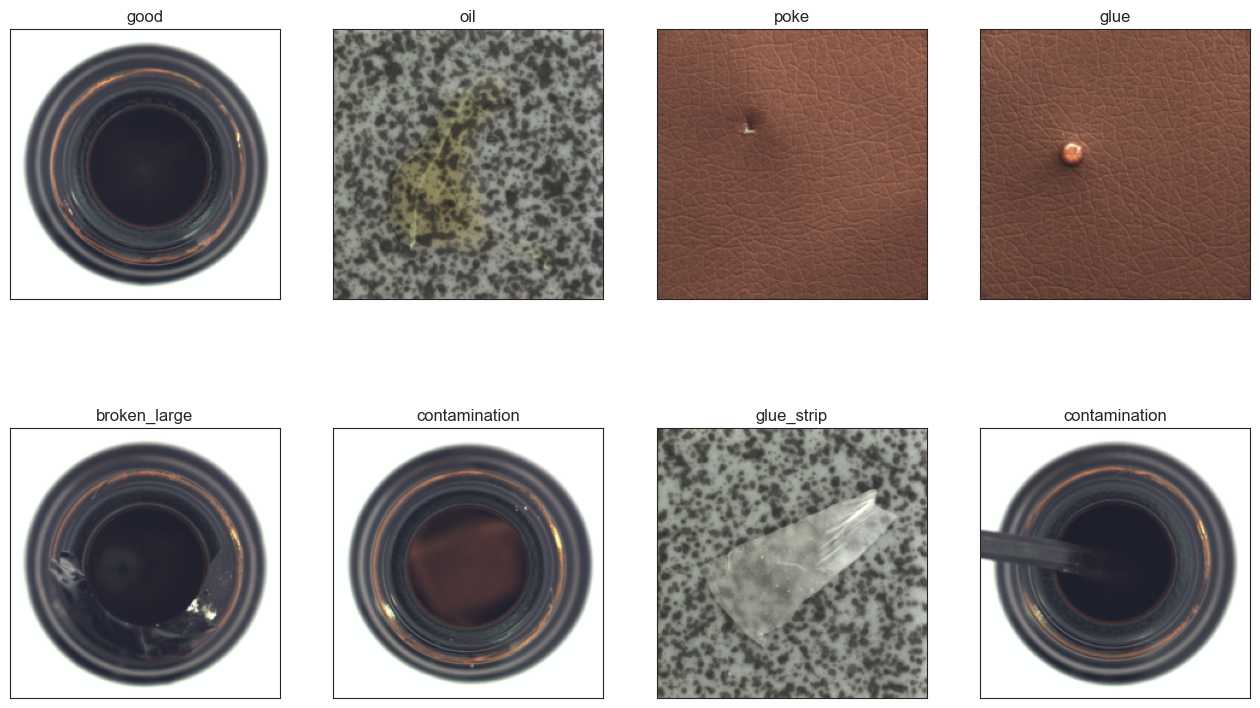

In [49]:
def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))

    with sns.axes_style("white"):
        fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))

    axes = [ax for row in axes for ax in row]

    for j, ax in enumerate(axes[:8]):
        img = images[j]
        label = labels[j]

        plt.sca(ax)
        show_image(img, label)

    plt.show()


train_example_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)

test_example_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=True)

print("TRAINING IMAGES")
show_dataset_examples(train_example_loader)
print("TESTING IMAGES")
show_dataset_examples(test_example_loader)

## Embed training features, compare to Test data and draw conclusion

In [50]:
EMBEDDING_FILE_EXT = "embeddings.npz"

def save_embeddings_compressed(embeddings, save_path="./embeddings", dataset_name="train"):
    """
    Args:
        embeddings: List of (embedding, label) tuples
        save_path: Directory to save files
        dataset_name: Base name for the files
    """
    save_path = Path(save_path)
    save_path.mkdir(parents=True, exist_ok=True)

    # Separate embeddings and labels
    emb_arrays = np.array([emb for emb, _ in embeddings])
    labels = np.array([label for _, label in embeddings])

    # Save as compressed numpy
    npz_path = save_path / f"{dataset_name}_{EMBEDDING_FILE_EXT}"
    np.savez_compressed(npz_path, embeddings=emb_arrays, labels=labels)

    # print(f"✓ Compressed embeddings saved to: {npz_path}")
    # print(f"  File size: {os.path.getsize(npz_path) / 1e6:.2f} MB")

    return npz_path


def load_embeddings_compressed(npz_path):
    """
    Load embeddings from compressed numpy format.

    Args:
        npz_path: Path to .npz file

    Returns:
        embeddings: List of (embedding_array, label) tuples
    """

    data = np.load(npz_path)
    emb_arrays = data["embeddings"]
    labels = data["labels"]

    # Convert to list of tuples
    embeddings = [(emb_arrays[i], labels[i]) for i in range(len(labels))]


    return embeddings

In [ ]:
def embed_and_save_features(
    dataloader, split, model_url="vit_small_patch16_dinov3_qkvb.lvd1689m"
):
    """
    Efficient, stable DINOv3 patch embedding extractor.
    Uses mean pooling over patch tokens → 384-dim embeddings.
    """
    model = timm.create_model(model_url, pretrained=True).to(device)
    model.eval()

    embeddings = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):

            images = images.to(device)

            feats = model.forward_features(images)

            # ---- PATCH TOKEN EXTRACTION (best for accuracy) ----
            if isinstance(feats, dict):
                x = feats.get("x_norm")  # (B, num_patches, 384)
            else:
                x = feats  # fallback

            # ---- MEAN POOL OVER PATCHES (optimal) ----
            emb = x.mean(dim=1)  # (B, 384)

            emb = emb.cpu().numpy()

            for i, label in enumerate(labels):
                lbl = label.item() if isinstance(label, torch.Tensor) else label
                embeddings.append((emb[i], lbl))

            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx+1} batches")

    save_embeddings_compressed(embeddings=embeddings, dataset_name=split)
    return embeddings

In [ ]:
def cosine_sim_matrix(test_vec, gt_mat):
    return (gt_mat @ test_vec).ravel()  # already normalized


def compare_and_draw_conclusion(
    threshold=0.8, rank=10, csv_path="results.csv", embedding_folder="./embeddings"
):
    train_path = f"{embedding_folder}/train_{EMBEDDING_FILE_EXT}"
    test_path = f"{embedding_folder}/test_{EMBEDDING_FILE_EXT}"

    embeddings_GT = (
        load_embeddings_compressed(train_path)
        if os.path.exists(train_path)
        else embed_and_save_features(train_loader, "train")
    )

    embeddings_Test = (
        load_embeddings_compressed(test_path)
        if os.path.exists(test_path)
        else embed_and_save_features(test_loader, "test")
    )

    gt_vecs, _ = zip(*embeddings_GT)
    gt_mat = np.asarray(gt_vecs, dtype=np.float32)

    # Normalize GT matrix once
    gt_mat /= np.linalg.norm(gt_mat, axis=1, keepdims=True) + 1e-8

    results = []

    y_true = []
    y_pred = []

    for idx, (test_vec, label) in enumerate(embeddings_Test):

        tv = np.asarray(test_vec, dtype=np.float32)
        tv /= np.linalg.norm(tv) + 1e-8

        sims = cosine_sim_matrix(tv, gt_mat)

        kth = np.partition(sims, -rank)[-rank] if len(sims) >= rank else sims.max()

        pred = "good" if kth > threshold else "anomalous"
        true = "good" if str(label).lower() == "good" else "anomalous"

        y_true.append(1 if true == "good" else 0)
        y_pred.append(1 if pred == "good" else 0)

        results.append(
            {
                "Test_Index": idx + 1,
                "True_Label": true,
                "Predicted_Label": pred,
                f"{rank}th_Best_Similarity": kth,
            }
        )

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Add summary row
    results.append(
        {
            "Test_Index": "TOTAL",
            "True_Label": "",
            "Predicted_Label": "",
            f"{rank}th_Best_Similarity": "",
            "Accuracy": f"{accuracy*100:.2f}%",
            "Precision": f"{precision*100:.2f}%",
            "Recall": f"{recall*100:.2f}%",
            "F1": f"{f1*100:.2f}%",
        }
    )

    return accuracy, precision, recall, f1


In [ ]:
# on GPU it takes roughly 3 minutes 18s to process all training and testing embeddings

compare_and_draw_conclusion(threshold=0.97, rank=1)

Processed 10 batches
Processed 20 batches
Processed 30 batches
Processed 40 batches
Processed 50 batches
Processed 60 batches
Processed 70 batches
Processed 80 batches
Processed 90 batches
Processed 100 batches
Processed 110 batches
Processed 120 batches
Processed 10 batches
Processed 20 batches
Processed 30 batches
Processed 40 batches
Processed 50 batches


(0.7845804988662132, 0.95, 0.168141592920354, 0.2857142857142857)

# PCA Viz per Cat
## Overlap embeddings

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def pca_overlap_train_test(train_npz, test_npz, title_prefix="PCA Overlap"):

    # Load data
    train_data = np.load(train_npz, allow_pickle=True)
    test_data  = np.load(test_npz,  allow_pickle=True)

    train_emb = train_data["embeddings"]
    train_lbl = train_data["labels"]

    test_emb = test_data["embeddings"]
    test_lbl = test_data["labels"]

    # Unique categories in training set
    categories = sorted(set(map(str, train_lbl)))

    for cat in categories:
        # Collect train samples of this category
        train_vecs = np.array([v for v, l in zip(train_emb, train_lbl) if str(l) == cat])

        if len(train_vecs) < 2:
            print(f"Skipping '{cat}' — need ≥2 train samples (got {len(train_vecs)})")
            continue

        # Collect test samples of this category
        test_vecs = np.array([v for v, l in zip(test_emb, test_lbl) if str(l) == cat])

        if len(test_vecs) == 0:
            print(f"No test samples for category '{cat}'")
            continue

        # Fit PCA ONLY on train data
        pca = PCA(n_components=2)
        train_proj = pca.fit_transform(train_vecs)
        test_proj  = pca.transform(test_vecs)   # IMPORTANT: same PCA space

        # Plot
        plt.figure(figsize=(5, 5))
        plt.scatter(train_proj[:, 0], train_proj[:, 1], label="Train", s=10)
        plt.scatter(test_proj[:, 0],  test_proj[:, 1],  label="Test",  s=10)
        plt.legend()
        plt.title(f"{title_prefix} — {cat}")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.axis("equal")
        plt.tight_layout()
        plt.show()


## Create Embeddings for PCA per Category

Processing category: bottle
Processing category: cable
Processing category: capsule
Processing category: carpet
Processing category: grid
Processing category: hazelnut
Processing category: leather
Processing category: metal_nut
Processing category: pill
Processing category: screw
Processing category: tile
Processing category: toothbrush
Processing category: transistor
Processing category: wood
Processing category: zipper


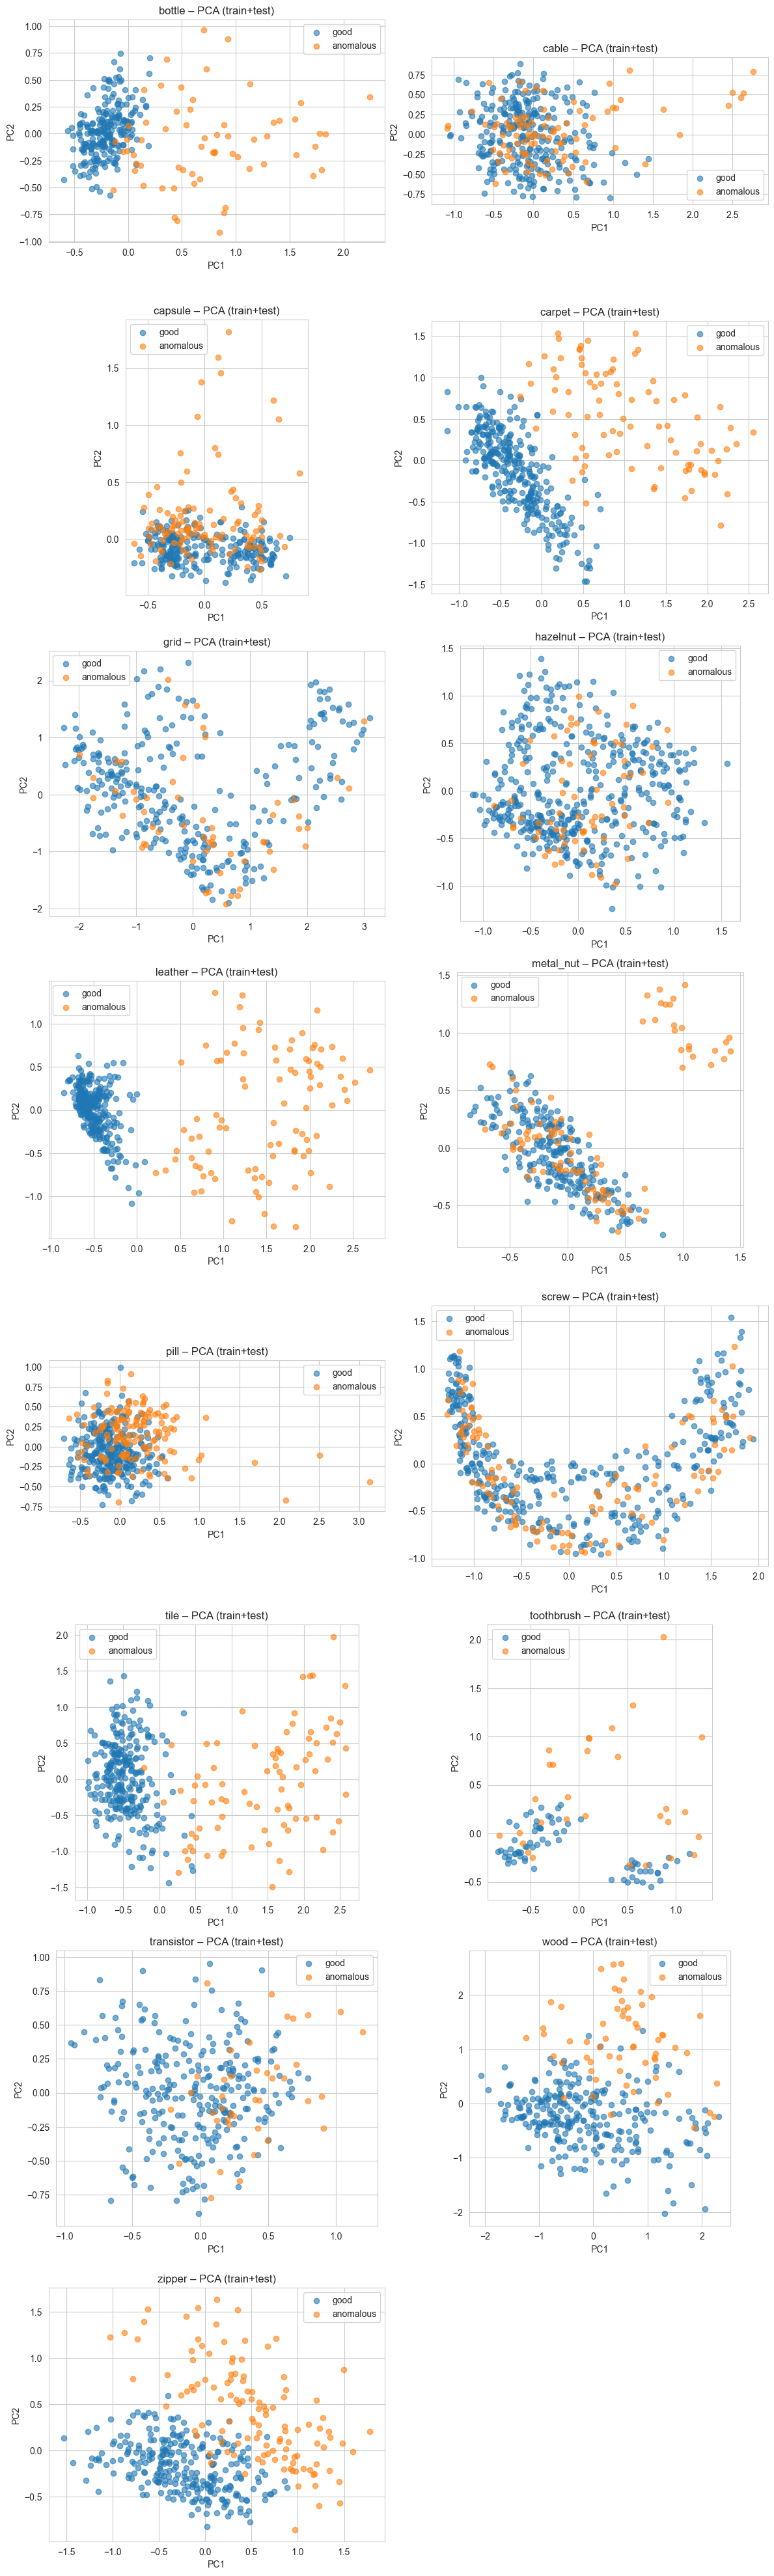

In [ ]:
import math
import numpy as np
import torch
import timm
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# =============== CONFIG ===============

MODEL_URL = "vit_small_patch16_dinov3_qkvb.lvd1689m"

# Create model once, reuse for all categories
base_model = timm.create_model(MODEL_URL, pretrained=True).to("cpu")
base_model.eval()


# =============== DATA HELPERS ===============

def get_category_loader(category, split):
    """
    Returns a DataLoader for one category and one split ('train' or 'test').

    Expects MVTec-style folder layout:
        Dataset/category/train/...
        Dataset/category/test/...
    """
    dataset = MVTecDataset(
        root_dir=MVTEC_ROOT,
        category=category,
        split=split,
        transform=transform,
        cache=False
    )
    loader = DataLoader(
        dataset=dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0
    )
    return loader


def embed_category_all_splits(category, model):
    """
    Loads ALL images for a category from BOTH:
      - split='train' (good images)
      - split='test'  (good + anomalous images)

    Returns:
        embeddings: np.ndarray of shape (N, D)
        labels:     np.ndarray of defect_type strings (e.g. 'good', 'scratch', ...)
    """
    all_embs = []
    all_labels = []

    with torch.no_grad():
        for split in ["train", "test"]:
            loader = get_category_loader(category, split=split)

            for images, defect_types in loader:
                images = images.to("cpu")

                feats = model.forward_features(images)
                # For DINOv3 ViT in timm, features are usually in dict with key "x_norm"
                if isinstance(feats, dict):
                    x = feats.get("x_norm")
                else:
                    x = feats

                # Max over patch dimension → single embedding per image
                emb = x.mean(dim=1)  # (B, D)
                all_embs.append(emb.cpu().numpy())
                all_labels.extend(defect_types)

    embeddings = np.concatenate(all_embs, axis=0)
    labels = np.array(all_labels)

    return embeddings, labels


# =============== PCA + SUBPLOTS ===============

def plot_pca_subplots(categories, model):
    """
    For each category in `categories`, load ALL train+test images,
    compute embeddings, do PCA to 2D, and plot them as subplots.

    Good images:      label == "good"
    Anomalous images: label != "good"
    """
    n = len(categories)
    if n == 0:
        print("No categories provided.")
        return

    # Arrange subplots in 2 columns
    cols = 2 if n > 1 else 1
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    if n == 1:
        axes = np.array([axes])  # make it iterable

    axes = axes.flatten()

    for idx, category in enumerate(categories):
        ax = axes[idx]

        print(f"Processing category: {category}")
        embeddings, labels = embed_category_all_splits(category, model)

        if embeddings.shape[0] < 2:
            ax.set_title(f"{category} – not enough samples for PCA")
            ax.axis("off")
            continue

        # good vs anomalous
        is_good = labels == "good"
        is_anom = labels != "good"

        # PCA → 2D
        pca = PCA(n_components=2, random_state=0)
        embs_2d = pca.fit_transform(embeddings)

        # Plot good images
        if np.any(is_good):
            ax.scatter(
                embs_2d[is_good, 0],
                embs_2d[is_good, 1],
                alpha=0.6,
                label="good"
            )

        # Plot anomalous images
        if np.any(is_anom):
            ax.scatter(
                embs_2d[is_anom, 0],
                embs_2d[is_anom, 1],
                alpha=0.6,
                label="anomalous"
            )

        ax.set_title(f"{category} – PCA (train+test)")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.legend()
        ax.set_aspect("equal")

    # Hide any unused axes
    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


# =============== RUN FOR ALL ===============

plot_pca_subplots(all_categories, base_model)
